In [1]:
!pip install chess

import numpy as np
import requests
import zipfile
import random
import gzip
import shutil
import chess
import chess.polyglot
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 148 kB 6.7 MB/s 


In [2]:
# selects the best move out of the legal moves 
def best_move(board):
  legal_moves = board.legal_moves
  best_eval = -np.inf
  best_move = None
  # loop over all legal moves in current position
  for move in legal_moves:
    board.push(move)
    # use evaluation function to decide strength of move
    cur_eval = position_eval(board) 
    # if eval of current move is better than previous moves replace best move
    if cur_eval > best_eval:
      best_move = move
    board.pop()
  return best_move, best_eval

In [3]:
board = chess.Board()

In [4]:
url = "https://digilander.libero.it/taioscacchi/archivio/Human-polyglot.zip"
r = requests.get(url, allow_redirects=True)
open('opening_book.zip', 'wb').write(r.content)
with zipfile.ZipFile('opening_book.zip', 'r') as zip_ref:
    zip_ref.extractall()

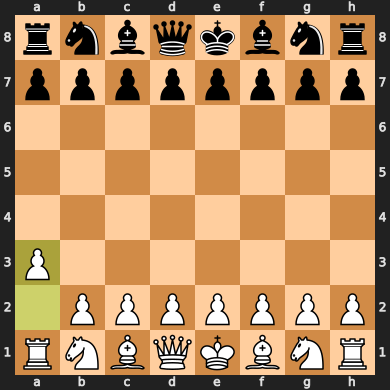

In [ ]:
book_moves = []
with chess.polyglot.open_reader("Human.bin") as reader:
  for entry in reader.find_all(board):
    book_moves.append(entry.move)
if len(book_moves) > 0:
  move = random.choice(book_moves)
else:
  move, _ = best_move(board)
board.push(move)
board

In [5]:
url = "https://storage.googleapis.com/chesspic/datasets/2021-07-31-lichess-evaluations-37MM.db.gz"
r = requests.get(url, allow_redirects=True)
open('position_eval.db.gz', 'wb').write(r.content)
with gzip.open('position_eval.db.gz', 'rb') as f_in:
    with open('position_eval.db', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [6]:
import sqlite3

dbfile = 'position_eval.db'

con = sqlite3.connect(dbfile)
cur = con.cursor()

position_eval_list = []
for row in cur.execute("SELECT fen, eval FROM evaluations"):
    position_eval_list.append(row)

con.close()

In [55]:
# convert board representation into 8x8x12 list with values for pieces
def representation_from_board_v1(fen):
  board = chess.Board(fen)
  representation = [[[None for x in range(8)] for y in range(8)] for z in range(12)]
  for num in range(12):
    for col in range(8):
      for row in range(8):
        square = col*8 + row
        piece = str(board.piece_at(square))
        white_attacks = len(board.attackers(0, square))
        black_attacks = len(board.attackers(1, square))
        if piece=='P' and num==0:
          representation[num][col][row] = (110.0)
        elif piece=='p' and num==6:
          representation[num][col][row] = (90.0)
        elif piece=='N' and num==1:
          representation[num][col][row] = (132.0)
        elif piece=='n' and num==7:
          representation[num][col][row] = (68.0)
        elif piece=='B' and num==2:
          representation[num][col][row] = (133.0)
        elif piece=='b' and num==8:
          representation[num][col][row] = (67.0)
        elif piece=='R' and num==3:
          representation[num][col][row] = (150.0)
        elif piece=='r' and num==9:
          representation[num][col][row] = (50.0)
        elif piece=='Q' and num==4:
          representation[num][col][row] = (190.0)
        elif piece=='q' and num==10:
          representation[num][col][row] = (10.0)
        elif piece=='K' and num==5:
          representation[num][col][row] = (199.0)
        elif piece=='k' and num==11:
          representation[num][col][row] = (1.0)
        else:
          representation[num][col][row] = (float(100 + white_attacks - black_attacks))
        representation[num][col][row] /= 200.0

  return representation


  # convert board representation into 
  def representation_from_board_v2(fen):
    board = chess.Board(fen)
    representation = board.attacks

In [125]:
# split dataset into train and test part
train_data_raw = position_eval_list[:2000]
test_data_raw = position_eval_list[2000:2200]

#test_data.append((data_point, torch.tensor((100.0 + position[1]))))
# convert using above function
train_data = []
test_data = []
for position in train_data_raw:
  data_point = torch.tensor(representation_from_board_v1(position[0]))
  if position[1] > 0:
    train_data.append((data_point, torch.tensor([0])))
  elif position[1] < 0:
    train_data.append((data_point, torch.tensor([2])))
  else:
    train_data.append((data_point, torch.tensor([1])))

for position in test_data_raw:
  data_point = torch.tensor(representation_from_board_v1(position[0]))
  if position[1] > 0:
    test_data.append((data_point, torch.tensor([0])))
  elif position[1] < 0:
    test_data.append((data_point, torch.tensor([2])))
  else:
    test_data.append((data_point, torch.tensor([1])))

In [115]:
print(train_data[1])

(tensor([[[0.5000, 0.4950, 0.4950, 0.4950, 0.4950, 0.4950, 0.4950, 0.5000],
         [0.5500, 0.5500, 0.5500, 0.4800, 0.5500, 0.5500, 0.5500, 0.5500],
         [0.4900, 0.4900, 0.4900, 0.4850, 0.4900, 0.4850, 0.4900, 0.4950],
         [0.5000, 0.5000, 0.5050, 0.5500, 0.5050, 0.4950, 0.5050, 0.5000],
         [0.5000, 0.5000, 0.4950, 0.5050, 0.4950, 0.5050, 0.4950, 0.5000],
         [0.5100, 0.5100, 0.5100, 0.5150, 0.5100, 0.5150, 0.5100, 0.5050],
         [0.5050, 0.5050, 0.5050, 0.5200, 0.5200, 0.5050, 0.5050, 0.5050],
         [0.5000, 0.5050, 0.5050, 0.5050, 0.5050, 0.5050, 0.5050, 0.5000]],

        [[0.5000, 0.6600, 0.4950, 0.4950, 0.4950, 0.4950, 0.6600, 0.5000],
         [0.4950, 0.4950, 0.4950, 0.4800, 0.4800, 0.4950, 0.4950, 0.4950],
         [0.4900, 0.4900, 0.4900, 0.4850, 0.4900, 0.4850, 0.4900, 0.4950],
         [0.5000, 0.5000, 0.5050, 0.4950, 0.5050, 0.4950, 0.5050, 0.5000],
         [0.5000, 0.5000, 0.4950, 0.5050, 0.4950, 0.5050, 0.4950, 0.5000],
         [0.5100, 0.51

In [126]:
class ChessNet(nn.Module):

  def __init__(self):
    super(ChessNet, self).__init__()
    # layers
    self.conv1 = nn.Conv2d(12, 6, 1, padding=1)
    self.conv2 = nn.Conv2d(6, 1, 1, padding=1)
    #self.conv3 = nn.Conv2d(6, 4, 2, padding=1)
    #self.conv4 = nn.Conv2d(4, 1, 2, padding=1)
    self.fc1 = nn.Linear(144 * 1 * 1, 32)
    self.fc2 = nn.Linear(32, 16)
    self.fc3 = nn.Linear(16, 3)
    torch


  def forward(self, x):
        print(x)
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), 1)
        print('layer1')
        print(x)
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 1)
        print('layer2')
        print(x)
        #x = F.max_pool2d(F.relu(self.conv3(x)), 1)
        #print('layer3')
        #print(x)
        #x = F.max_pool2d(F.relu(self.conv4(x)), 1)
        #print('layer4')
        #print(x)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        print('layer5')
        print(x)
        x = F.relu(self.fc2(x))
        print('layer6')
        print(x)
        x = F.relu(self.fc3(x))
        print('layer7')
        print(x)
        return x

net = ChessNet()
print(net)

ChessNet(
  (conv1): Conv2d(12, 6, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 1, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=144, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=3, bias=True)
)


In [100]:
input = (train_data[100][0])
print(input)
result = (train_data[100][1])
print(result)
out = net(input)
print(out)

tensor([[[0.5000, 0.5000, 0.5050, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5050, 0.5000, 0.5050, 0.5000, 0.5050],
         [0.5000, 0.5500, 0.5000, 0.5000, 0.5100, 0.5000, 0.5000, 0.5000],
         [0.4950, 0.4900, 0.4900, 0.4950, 0.5000, 0.5050, 0.5000, 0.5050],
         [0.5000, 0.4900, 0.5000, 0.4950, 0.5050, 0.5500, 0.5000, 0.5500],
         [0.4950, 0.4950, 0.4900, 0.4900, 0.4900, 0.5100, 0.4900, 0.5100],
         [0.5000, 0.4950, 0.5000, 0.5000, 0.5050, 0.5050, 0.5000, 0.5050],
         [0.5000, 0.4950, 0.5000, 0.5050, 0.5000, 0.5050, 0.5050, 0.5050]],

        [[0.5000, 0.5000, 0.5050, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5050, 0.5000, 0.5050, 0.5000, 0.5050],
         [0.5000, 0.4950, 0.5000, 0.5000, 0.5100, 0.5000, 0.5000, 0.5000],
         [0.4950, 0.4900, 0.4900, 0.4950, 0.5000, 0.5050, 0.5000, 0.5050],
         [0.5000, 0.4900, 0.5000, 0.4950, 0.5050, 0.5000, 0.5000, 0.5000],
         [0.4950, 0.495

In [46]:
net.zero_grad()
out.backward(torch.randn(1, 3))

In [127]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

for data in train_data:
  input = data[0]
  #print(input)
  target = data[1]
  #target = target.view(1, -1)
  optimizer.zero_grad()   # zero the gradient buffers
  output = net(input)
  print(output)
  loss = criterion(output, target)
  loss.backward()
  optimizer.step()    # Does the update
  print(net.conv1.bias.grad)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
         [0.2137, 0.2137, 0.2137, 0.2137, 0.2137, 0.2137, 0.2137, 0.2137,
          0.2137, 0.2137]],

        [[0.0326, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326, 0.0326,
          0.0326, 0.0326],
         [0.0326, 0.0000, 0.0000, 0.0000, 0.0000, 0.0421, 0.0000, 0.0000,
          0.0000, 0.0326],
         [0.0326, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0326],
         [0.0326, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0326],
         [0.0326, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0326],
         [0.0326, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0326],
         [0.0326, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0326],
         [0.0326, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0326],
         [0.0326, 0.00

In [128]:
output = net(test_data[125][0])
print(output, test_data[125][1])

tensor([[[0.5000, 0.5000, 0.5050, 0.5000, 0.5050, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5050, 0.4950, 0.5000, 0.4950, 0.5050, 0.5000, 0.5000],
         [0.5000, 0.4950, 0.5000, 0.5000, 0.5000, 0.4950, 0.5500, 0.5500],
         [0.5000, 0.5100, 0.5050, 0.5050, 0.5050, 0.5500, 0.5000, 0.4950],
         [0.5500, 0.5000, 0.5050, 0.5000, 0.4950, 0.4900, 0.4950, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.4950, 0.5000, 0.5050, 0.5050],
         [0.5000, 0.5000, 0.5000, 0.4950, 0.4950, 0.4950, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000]],

        [[0.5000, 0.5000, 0.5050, 0.5000, 0.5050, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5050, 0.4950, 0.5000, 0.4950, 0.5050, 0.5000, 0.5000],
         [0.5000, 0.4950, 0.5000, 0.5000, 0.5000, 0.4950, 0.5000, 0.5000],
         [0.5000, 0.5100, 0.5050, 0.6600, 0.5050, 0.5000, 0.5000, 0.4950],
         [0.5000, 0.5000, 0.5050, 0.5000, 0.4950, 0.4900, 0.4950, 0.5000],
         [0.5000, 0.500

Files already downloaded and verified
Files already downloaded and verified


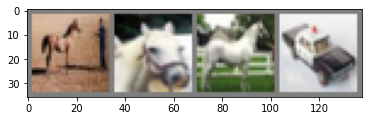

horse horse horse car  


In [106]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [108]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        print('inputs', 'labels')
        print(inputs, labels)

print('Finished Training')

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.


        [[[ 0.4118,  0.3961,  0.3882,  ...,  0.4510,  0.4275,  0.4196],
          [ 0.4118,  0.3961,  0.3961,  ...,  0.4902,  0.4510,  0.4275],
          [ 0.4118,  0.4118,  0.4275,  ...,  0.4353,  0.4196,  0.4510],
          ...,
          [ 0.2000,  0.2471,  0.2549,  ...,  0.3020,  0.4118,  0.4667],
          [ 0.1686,  0.2392,  0.2392,  ...,  0.3647,  0.3647,  0.4196],
          [ 0.1373,  0.1529,  0.1373,  ...,  0.3961,  0.3255,  0.3490]],

         [[ 0.4275,  0.4118,  0.4118,  ...,  0.3725,  0.3569,  0.3490],
          [ 0.4039,  0.3961,  0.3961,  ...,  0.3725,  0.3412,  0.3333],
          [ 0.3804,  0.3804,  0.3961,  ...,  0.2627,  0.2784,  0.3412],
          ...,
          [-0.1059, -0.1608, -0.1922,  ..., -0.3725, -0.3098, -0.2392],
          [-0.1216, -0.1608, -0.2078,  ..., -0.3020, -0.3412, -0.2784],
          [-0.0980, -0.1216, -0.1451,  ..., -0.2863, -0.3098, -0.3333]],

         [[ 0.3255,  0.3098,  0.3

KeyboardInterrupt: ignored